In [1]:
import os
import pandas as pd
os.chdir("C:/Users/navpa/Downloads")

In [2]:
df = pd.read_csv('combined_csv.csv', encoding = 'unicode_escape')
#full_text is fine

In [3]:
df_copy = df
print(len(df_copy))
serlis=df_copy.duplicated().tolist()
print(serlis.count(True)) #7479

12870
0


In [4]:
serlis=df_copy.duplicated(['Text']).tolist()
print(serlis.count(True))

420


In [5]:
import re
import time
import nltk
nltk.download('stopwords')
from nltk.corpus import sentiwordnet as swn
from nltk.tag import pos_tag,map_tag
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\navpa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
pstem = PorterStemmer()
lem = WordNetLemmatizer()
stop_words = stopwords.words('english')

In [7]:
def clean_df(df_copy):

    for i in range(len(df_copy)):
        txt = df_copy.loc[i]["Text"]
        txt=re.sub(r'@[A-Z0-9a-z_:]+','',txt)
        txt=re.sub(r'^[RT]+','',txt)
        txt = re.sub('https?://[A-Za-z0-9./]+','',txt)
        txt=re.sub("[^a-zA-Z]", " ",txt)
        df_copy.at[i,"Text"]=txt
    
    from afinn import Afinn
    af = Afinn()
    count_total=0
    count_pos=0
    count_neut=0
    count_neg=0
    li_af = []
    for i in range(len(df.index)):
        sent = str(df.loc[i]['Text'])
        if(af.score(sent)>0):
            count_pos=count_pos+1
            count_total=count_total+1
            li_af.append(1)
        elif(af.score(sent)<0):
            count_neg=count_neg+1
            count_total=count_total+1
            li_af.append(-1)
        else:
            li_af.append(0)
            count_total=count_total+1
            count_neut+=1

    print("Total tweets:",len(df.index))
    print("Total tweets with sentiment:",count_total)
    print("positive tweets:",count_pos)
    print("negative tweets:",count_neg)
    print("neutral tweets:",count_neut)
    
    df_copy['Sentiment'] = li_af 
    return df_copy

In [9]:
st=time.time()
df_copy = clean_df(df_copy)
end=time.time()


Total tweets: 12870
Total tweets with sentiment: 12870
positive tweets: 4026
negative tweets: 2548
neutral tweets: 6296


In [10]:
df_copy.head()

,ï»¿Datetime,Sentiment,Text,Unnamed: 0,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,2020-04-08 18:07:41+00:00,0,...,0,NaN,NaN,NaN,NaN
1,2020-04-08 18:07:11+00:00,1,Jennifer Lopez The best way to stop the spread...,1,NaN,NaN,NaN,NaN
2,2020-04-08 18:06:18+00:00,1,ip of the day lockdown advice As everyone ha...,2,NaN,NaN,NaN,NaN
3,2020-04-08 18:06:16+00:00,-1,Corona ...,3,NaN,NaN,NaN,NaN
4,2020-04-08 18:04:18+00:00,-1,Corona Our muslim brothers listen to this Sau...,4,NaN,NaN,NaN,NaN


In [11]:
df_copy.to_csv('All.csv',index=False)

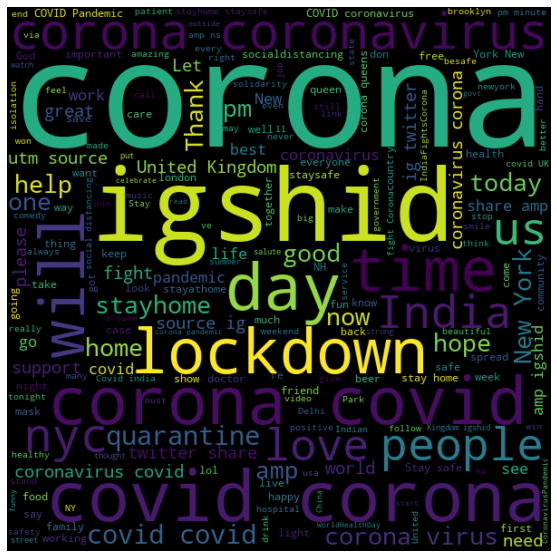

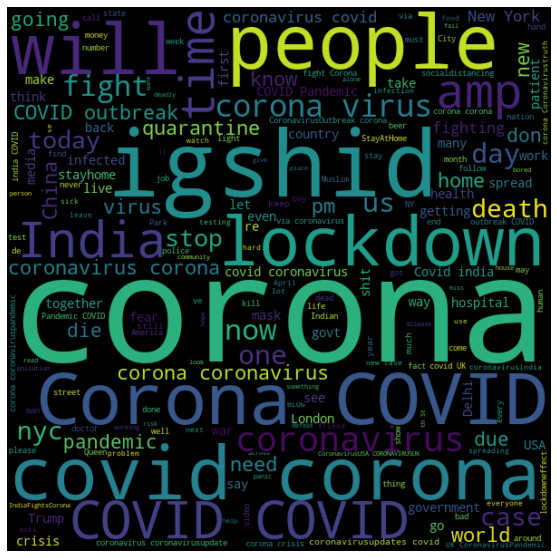

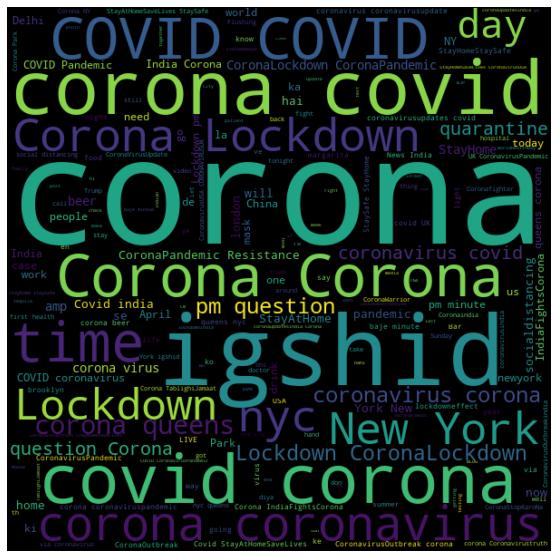

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

pos_text=""
neg_text=""
neut_text=""

for i in range(len(df_copy.index)):
    if(df_copy.loc[i]["Sentiment"]==1):
        pos_text+=df_copy.loc[i]["Text"]
    elif(df_copy.loc[i]["Sentiment"]==-1):
        neg_text+=df_copy.loc[i]["Text"]
    else:
        neut_text+=df_copy.loc[i]["Text"]

list_text = [pos_text,neg_text,neut_text]


for txt in list_text:
    word_cloud = WordCloud(width = 600,height = 600,max_font_size = 200).generate(txt)
    plt.figure(figsize=(12,10))
    plt.imshow(word_cloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [14]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
SEED =4

x = df_copy.Text
y = df_copy.Sentiment

x_train,x_val_test,y_train,y_val_test = train_test_split(x,y,test_size=0.1,random_state=SEED)
x_val,x_test,y_val,y_test = train_test_split(x_val_test,y_val_test,test_size=0.5,random_state=SEED)

x_train_copy = x_train
y_train_copy = y_train
x_val_copy = x_val
y_val_copy = y_val


In [15]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [16]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.model_selection import cross_validate,KFold
import datetime
import time
import pandas as pd

In [ ]:

classifiers = [MultinomialNB(),BernoulliNB(),LogisticRegression(),LinearSVC(),AdaBoostClassifier(),RidgeClassifier(),PassiveAggressiveClassifier(),Perceptron(),RandomForestClassifier()]
clf_names = ['MultinomialNB()','BernoulliNB()','LogisticRegression()','LinearSVC()','AdaBoostClassifier()','RidgeClassifier()','PassiveAggressiveClassifier()','Perceptron()','RandomForest Classifier']
data=[]

for v in ['cv','tf']:

    for gram in range(1,4):
        i=0

        for clf in classifiers:
            
            if(clf=='RandomForest Classifier'):#special case
                clf = RandomForestClassifier(random_state=0,n_jobs=-1,class_weight="balanced")

            before = datetime.datetime.now()
            before = before.strftime("%H:%M:%S")
            start = time.time()
            
            if(v=='cv'):
                vec = TfidfVectorizer(ngram_range=(1,gram))
            else:
                vec = CountVectorizer(ngram_range=(1,gram))
                
            model = make_pipeline(vec,clf)
            model.fit(x_train_copy.values.astype('U'),y_train_copy.values.astype('U'))##
            labels = model.predict(x_val_copy.values.astype('U'))
            ac = accuracy_score(y_val_copy.values.astype('U'),labels)
            kfold = KFold(n_splits=10,shuffle=False,random_state=None)
            results = cross_validate(model,x_train_copy.values.astype('U'),y_train_copy.values.astype('U'),cv=kfold, return_train_score=True)
            crossval_test_score_mean=results['test_score'].mean()
            crossval_train_score_mean=results['train_score'].mean()
            crossval_test_score_std=results['test_score'].std()
            crossval_train_score_std=results['train_score'].std()
            after = datetime.datetime.now()
            after = after.strftime("%H:%M:%S")
            end = time.time()
            hours = int(after[0:2])-int(before[0:2])
            mins = int(after[3:5])-int(before[3:5])
            secs = int(after[6:8])-int(before[6:8])
            time_taken = str(hours)+":"+str(mins)+":"+str(secs)
            gr = str(gram)
            vec_gram = v+"_"+gr
            data.append([vec_gram,clf_names[i],ac,crossval_train_score_mean,crossval_test_score_mean,crossval_train_score_std,crossval_test_score_std, end-start])
            i+=1

d = pd.DataFrame(data,columns=['Vec_Gram','Classifier','Ac','crossval_train_score_mean','crossval_test_score_mean','crossval_train_score_std','crossval_test_score_std','Time.2'])

fname = "all_clfs.csv"
d.to_csv(fname)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg